In [698]:
import pandas as pd
import random
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import unicodedata
#import inflect
import re
from itertools import chain
#!pip install contractions
#import contractions
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/mina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [626]:
#load in the csv contatining the data
df_original = pd.read_csv('wiki_movie_plots_deduped.csv')

In [627]:
# drop unknown values and unneccessary columns
df_all = df_original.drop(df_original[df_original['Genre'] == "unknown"].index, 
                          inplace = False)
df_all = df_all.drop(['Release Year','Origin/Ethnicity','Cast', 'Wiki Page','Director',
                      'Release Year'],axis=1,)

In [629]:
#Function to create dataframes for each genre; using 1000 elements for training 
def dataframe_creator(genre):
    genre = df_original.drop(df_original[df_original['Genre'] != genre].index, inplace = False)
    #genre.drop(['Release Year','Origin/Ethnicity','Cast', 'Wiki Page','Director','Release Year'],axis=1, 
    #           inplace = True)
    genre = genre.sample(frac=1)
    genre = genre.reset_index(drop=True)
    genre_train = genre[0:1000]
    genre_test = genre[1000:len(genre)]
    return (genre_train,genre_test)

In [630]:
#genres = list(set(genres))

In [631]:
#List of Genres we want to run analysis on
df_horror_train,df_horror_test = dataframe_creator('horror')
df_comedy_train,df_comedy_test = dataframe_creator('comedy')
df_drama_train, df_drama_test = dataframe_creator('drama')

#Creating dataframes for all genres for training
df_train = pd.concat([df_horror_train,df_comedy_train, df_drama_train])

#creating dataframes for all genres for testing
df_test = pd.concat([df_horror_test,df_comedy_test, df_drama_test])

In [632]:
# Check word type of a word
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [633]:
#Function for text pre-processing
def normalizeText(row):
    
    #create a list of punctuations we wish to delete
    punctuations = string.punctuation
    #create a list of stopwords in English
    stopWords = set(stopwords.words('english'))
    
    #change all letters to lower case
    row = row.lower()  
    
    #remove numbers
    row = re.sub(" \d+", " ", row)
                 
    #remove punctutation
    for letter in row: 
    
        if letter in punctuations: 
            row = row.replace(letter, "")
    
    #expand the contraction I'm -> I am
    #row = contractions.fix(row)
    # got it from (https://github.com/kootenpv/contractions)
                
    #remove accent char
    row = unicodedata.normalize('NFKD', row).encode('ascii', 'ignore').decode('utf-8', 'ignore')
                 
    #remove extra whitespace convert into a word  
    row = row.strip()
    
    # TOKENIZATION: process of splitting text into smaller piece called tokens.
    tokens = word_tokenize(row)
    
    # lemmatization step played -> play
    lemmatizer = WordNetLemmatizer()
    row = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(row)])
    
    #remove stop words such as "a", "the", "is"
    tokens = word_tokenize(row)
    row = ' '.join([i for i in tokens if not i in stopWords])
     
    return row

In [634]:
#run the column through the normalizing function
df_train["Plot"] = df_train["Plot"].apply(normalizeText)
df_test["Plot"] = df_test["Plot"].apply(normalizeText) 

In [652]:
# print most common words in df
def wordFrequency(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.title("Most Frequent Words")
    plt.show()
  


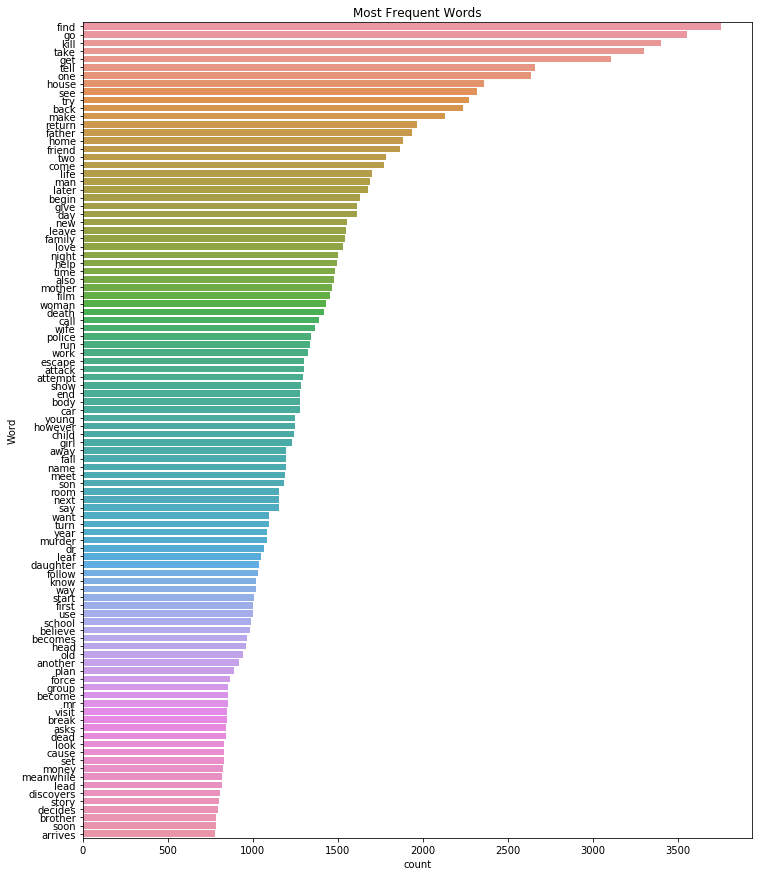

In [653]:
wordFrequency(df_train['Plot'], 100)

In [638]:
#Creating dataframes with just the plot, and genre of the test and training data

#need to randomize before splitting
df_train = df_train.sample(frac=1)
df_trian = df_train.reset_index(drop=True)
df_test = df_test.sample(frac=1)
df_test = df_test.reset_index(drop=True)

#Setting columns to individual dataframes
train_x = df_train['Plot']
train_y = df_train['Genre']
test_x = df_test['Plot']
test_y = df_test['Genre']

In [639]:
# Make list from df for "Plot" column
# Param: the df to use
#def dfToList(df, columnName):
#    lst = []
#    for i, rows in df.iterrows():
#        l = [rows[columnName]]
#        lst.append(l)
#    return list(chain.from_iterable(lst))

# tf-idf vectorisation
# Param: all plots from the df as a list (ie [plot1, plot2,...])
#def tfidfVec(plots):
#    vectorizer = TfidfVectorizer()
#    tfidf = vectorizer.fit_transform(plots)
#    feature_names = vectorizer.get_feature_names()
#    dense = tfidf.todense()
#    df_tfidf = pd.DataFrame(dense.tolist(), columns=feature_names)
#    return df_tfidf

In [640]:
# test showing how it works on first 5 elements of df_HandC
#tfidfVec(dfToList(df_train.head()))

In [ ]:
######################################################################################
# this was for having multi labelled genres, will look at it tomorrow morning 

In [624]:
# run normalise function on df_all
df_all["Plot"] = df_all["Plot"].apply(normalizeText) 

In [ ]:
# Multi label binarisation for multiple genre classification

mlb = MultiLabelBinarizer()
mlb.fit(df_all['Genre'])
y = mlb.transform(df_all['Genre'])

In [ ]:
######################################################################################

In [669]:
# Perform tfidf vectorisation on data
tfidf_vec = TfidfVectorizer()

train_x_tfidf = tfidf_vec.fit_transform(train_x)
test_x_tfidf = tfidf_vec.transform(test_x)

train_y_tfidf = tfidf_vec.fit_transform(train_y)
test_y_tfidf = tfidf_vec.transform(test_y)

In [693]:
# Grid Search to find the best parameters 
classifier = OneVsRestClassifier(SGDClassifier(loss="log", penalty="l2", class_weight="balanced"))
parameters = { "estimator__alpha": [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0] }

gsv = GridSearchCV(classifier, param_grid=parameters, scoring="f1_micro", n_jobs=-1)
gsv.fit(train_x_tfidf, train_y_tfidf)

print(gsv.best_score_)
print(gsv.best_params_)
best_alpha = gsv.best_params_['estimator__alpha']

0.7426772342701545
{'estimator__alpha': 0.001}


In [696]:
# Use OneVsRest Classifier with logistic regression as loss function
classifier = OneVsRestClassifier(SGDClassifier(loss="squared_loss", alpha=best_alpha, penalty="l2", class_weight="balanced"))
classifier.fit(train_x_tfidf, train_y_tfidf)
y_pred = classifier.predict(test_x_tfidf)

print("Accuracy:", metrics.accuracy_score(test_y_tfidf, y_pred))
print("Hamming Loss (number of incorrect labels):", 
      metrics.hamming_loss(test_y_tfidf, y_pred))


Accuracy: 0.5205640423031728
Hamming Loss (number of incorrect labels): 0.2164120642381512
